# <center> Decision Trees and k Nearest Neighbors


## 1. Decision Tree 
We begin our overview of classification methods with discussing decision trees. To build a decision tree, we can use any choice of impurity measure (e.g., Entropy, Gini, or misclassification error) and select an attribute for splitting at an internal node that provides the maximum gain in the impurity measure at the collection of children nodes obtained after splitting. Here is a plot of how different impurity measures vary with the probability of the positive class (p+) at any node.

In [15]:
# we don't like warnings
# you can comment the following 2 lines if you'd like to
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

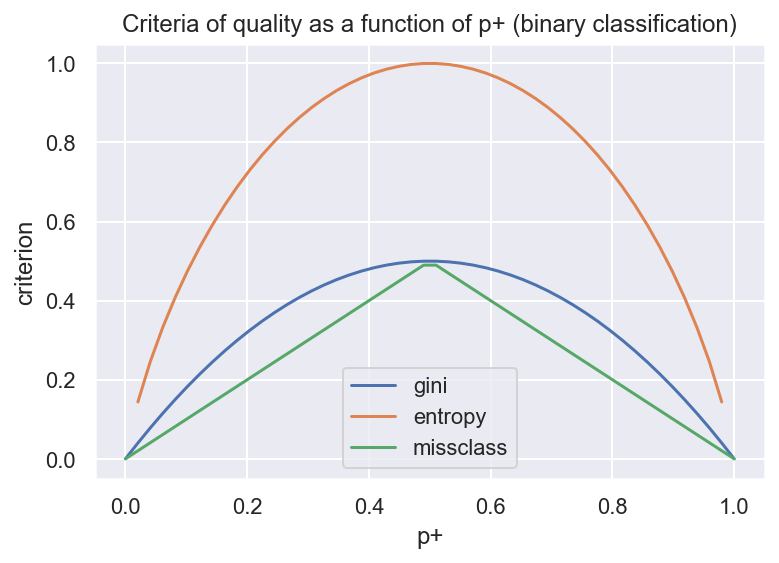

In [16]:
plt.figure(figsize=(6, 4))
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Criteria of quality as a function of p+ (binary classification)')
plt.legend();

### Decision Tree using Scikit-learn
Let's consider fitting a decision tree to some synthetic data. We will generate samples from two classes, both normal distributions but with different means.

In [17]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Let's plot the data.

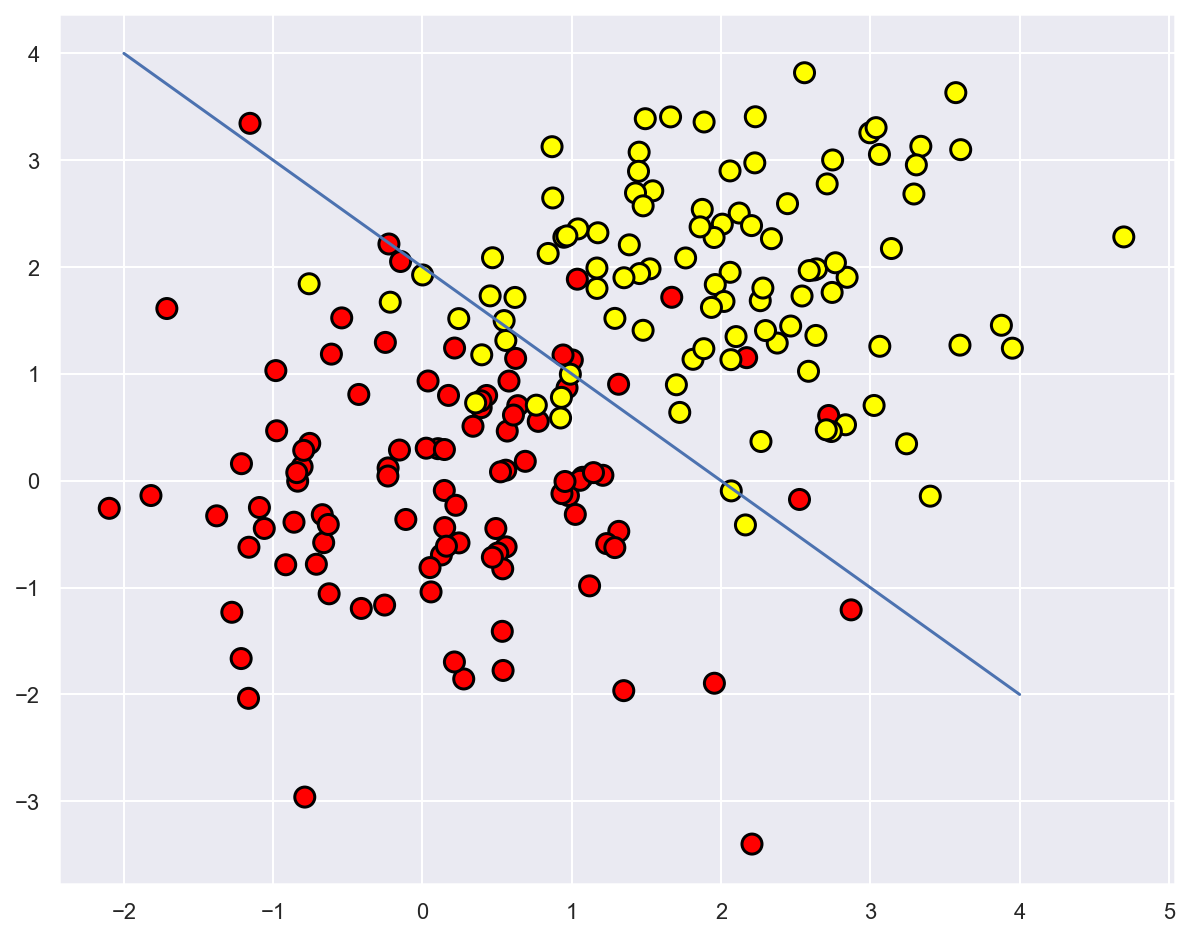

In [18]:
plt.figure(figsize=(10,8))
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));


Informally, the goal of classification here is to build a "good" decision boundary separating the two classes (the red dots from the yellow). A straight line will be too simple while some complex curve snaking by each red dot will be too complex and will lead us to making mistakes on new "unseen" samples. Intuitively, some smooth boundary would work well on new data.

### Class DecisionTreeClassifier in Scikit-learn
The main hyper-parameters of the [`sklearn.tree.DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class are:

- `max_depth` – the maximum depth of the tree;
- `criterion` - {“gini”, “entropy”}, default=”gini”
- `max_features` - the maximum number of features with which to search for the best partition (this is necessary with a large number of features because it would be "expensive" to search for partitions for *all* features);
- `min_samples_leaf` – the minimum number of samples in a leaf. This parameter prevents creating trees where any leaf would have only a few training instances.

The parameters of the tree need to be set depending on input data, and it is usually done by means of *cross-validation*, more on this later.

Let's try to separate the two classes of the synthetic dataset by training an `Sklearn` decision tree. We will use `max_depth` parameter that limits the depth of the tree. Let's visualize the resulting separating boundary.

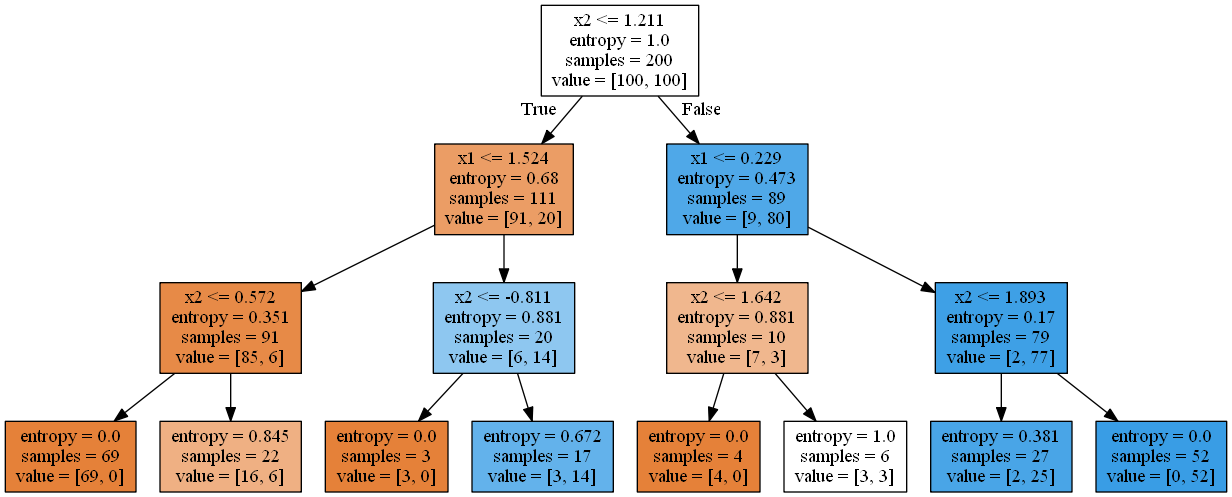

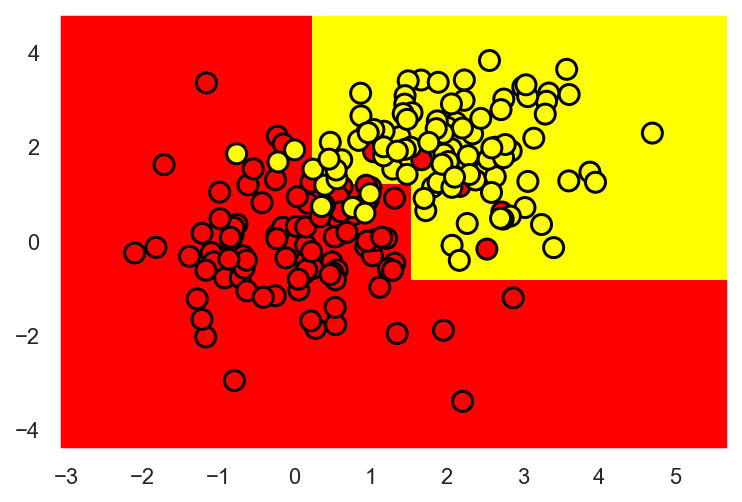

In [19]:
from sklearn.tree import DecisionTreeClassifier
import pydotplus #To install this package, run: conda install -c anaconda pydotplus
from sklearn.tree import export_graphviz #To install this package, run: conda install -c anaconda graphviz

# Let’s write an auxiliary function that will return grid for further visualization.

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)
    
    
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


#For the assignment, you have to change max_depth parameter and re-run this cell 

clf_tree = DecisionTreeClassifier(criterion='entropy',max_depth= 3, random_state=17)

# training the tree
clf_tree.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);


tree_graph_to_png(tree=clf_tree, feature_names=['x1', 'x2'], png_file_to_save='topic3_decision_tree1.png')

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "topic3_decision_tree1.png"
Image(filename = PATH , width=900, height=600)

And how does the tree itself look? We see that the tree "cuts" the space into 8 rectangles for max depth = 3, i.e. the tree has 8 leaves. Within each rectangle, the tree will make the prediction according to the majority label of the objects inside it.

#### How can we "read" such a tree?
**Explanation for tree with max_depth = 3**
In the beginning, there were 200 samples (instances), 100 of each class. The entropy at this stage was maximal, $S=1$. Then, the first partition of the samples into 2 groups was made by comparing the value of $x_2$ with $1.211$ (find this part of the border in the picture above). With that, the entropy of both left and right groups decreased. The process continues up to depth 3. In this visualization, the more samples of the first class, the darker the orange color of the vertex; the more samples of the second class, the darker the blue. At the beginning, the number of samples from two classes is equal, so the root node of the tree is white.

### How a Decision Tree Works with Numerical Features  [Bank Dataset]

Suppose we have a numeric feature "Age" that has a lot of unique values. A decision tree will look for the best split by checking binary attributes such as "Age <17", "Age < 22.87", and so on. But what if the age range is large? Or what if another quantitative variable, "salary", can also be "cut" in many ways? There will be too many binary attributes to select from at each step during tree construction. To resolve this problem, heuristics are usually used to limit the number of thresholds to which we compare the quantitative variable.
 
Let's consider an example. Suppose we have the following dataset:

In [20]:
data = pd.DataFrame({'Age': [17,64,18,20,38,49,55,25,29,31,33],
                     'Loan Default': [1,0,1,0,1,0,0,1,1,0,1]})
data

,Age,Loan Default
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


Let's sort it by age in ascending order.

In [21]:
data.sort_values('Age')

,Age,Loan Default
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


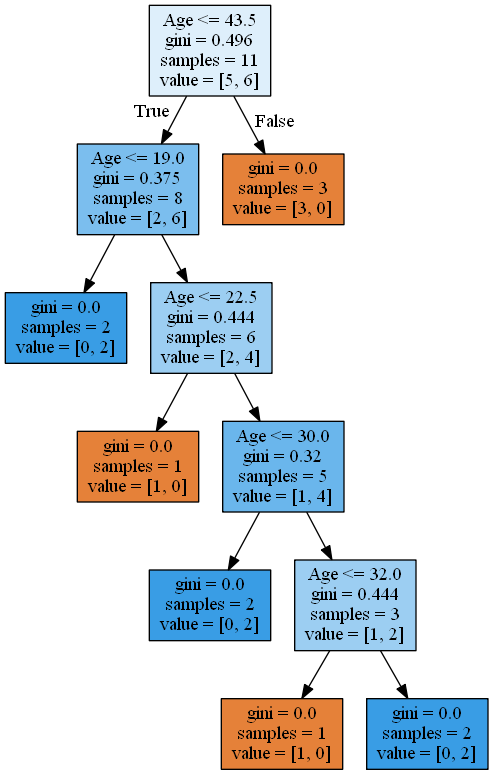

In [22]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data['Age'].values.reshape(-1, 1), data['Loan Default'].values)

tree_graph_to_png(age_tree, feature_names=['Age'], 
                 png_file_to_save='topic3_decision_tree2.png')

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "topic3_decision_tree2.png"
Image(filename = PATH , width=500, height=200)

We see that the tree used the following 5 values to evaluate by age: 43.5, 19, 22.5, 30, and 32 years. If you look closely, these are exactly the mean values between the ages at which the target class "switches" from 1 to 0 or 0 to 1. To illustrate further, 43.5 is the average of 38 and 49 years; a 38-year-old customer failed to return the loan whereas the 49-year-old did. The tree looks for the values at which the target class switches its value as a threshold for "cutting" a quantitative variable.

**Conclusion**: the simplest heuristics for handling numeric features in a decision tree is to sort its values in ascending order and check only those thresholds where the value of the target variable changes.

## 2. Nearest Neighbors Method

*The nearest neighbors method* (k-Nearest Neighbors, or k-NN) is another very popular classification method. The quality of classification with k-NN depends on several parameters:

- The number of neighbors $k$.
- The distance measure between samples (common ones include Hamming, Euclidean, cosine, and Minkowski distances). Note that most of these metrics require data to be scaled. Simply speaking, we do not want the "salary" feature, which is on the order of thousands, to affect the distance more than "age", which is generally less than 100. 
- Weights of neighbors (each neighbor may contribute different weights; for example, the further the sample, the lower the weight).

### Class `KNeighborsClassifier` in Scikit-learn
The main hyper-parameters of the class `sklearn.neighbors.KNeighborsClassifier` are:
- weights: `uniform` (all weights are equal), `distance` (the weight is inversely proportional to the distance from the test sample), or any other user-defined function;
- algorithm (optional): `brute`, `ball_tree `, `KD_tree`, or `auto`. In the first case, the nearest neighbors for each test case are computed by a grid search over the training set. In the second and third cases, the distances between the examples are stored in a tree to accelerate finding nearest neighbors. If you set this parameter to `auto`, the right way to find the neighbors will be automatically chosen based on the training set.
- leaf_size (optional): threshold for switching to grid search if the algorithm for finding neighbors is BallTree or KDTree;
- metric: `minkowski`, `manhattan `, `euclidean`, `chebyshev`, or other.

## 3. Choosing Model Parameters and Cross-Validation 

The main task of learning algorithms is to be able to *generalize* to unseen data. Since we cannot immediately check the model performance on new, incoming data (because we do not know the true values of the target variable yet), it is necessary to sacrifice a small portion of the data to check the quality of the model on it.


This is often done in one of two ways:
- setting aside a part of the dataset (*held-out/hold-out set*). Thus we reserve a fraction of the training set (typically from 20% to 40%), train the model on the remaining data (60-80% of the original set), and compute performance metrics for the model (e.g accuracy) on the hold-out set.
- *cross-validation*. The most frequent case here is *k-fold cross-validation*.

<img src="https://habrastorage.org/webt/80/nx/1p/80nx1pa4iet33x9pw-bj02khyhs.png" />

In k-fold cross-validation, the model is trained $K$ times on different ($K-1$) subsets of the original dataset (in white) and checked on the remaining subset (each time a different one, shown above in orange).
We obtain $K$ model quality assessments that are usually averaged to give an overall average quality of classification.

Cross-validation provides a better assessment of the model quality on new data compared to the hold-out set approach. However, cross-validation is computationally expensive when you have a lot of data.
 


In [23]:
from sklearn.model_selection import train_test_split

X = train_data
y = train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [24]:
X_train.shape

(160, 2)

In [25]:
X_test.shape

(40, 2)

In [26]:
y_train.shape

(160,)

In [27]:
y_test.shape

(40,)

## 4. Application Examples

### Decision trees and nearest neighbors method in a customer churn prediction task 

Let's read data into a `DataFrame` and preprocess it.  

In [28]:
df = pd.read_csv('telecom_churn.csv')

df['international plan'] = pd.factorize(df['international plan'])[0]
df['voice mail plan'] = pd.factorize(df['voice mail plan'])[0]
df['churn'] = df['churn'].astype('int')
states = df['state']
y = df['churn']
df.drop(['state', 'churn','phone number'], axis=1, inplace=True)

In [29]:
df.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


Let's allocate 70% of the set for training (`X_train`, `y_train`) and 30% for the hold-out set (`X_holdout`, `y_holdout`). The hold-out set will not be involved in tuning the hyper-parameters of the models. We'll use it at the end, after tuning, to assess the quality of the resulting model. Let's train 2 models: decision tree and k-NN. We do not know what hyper-parameters are good, so we will assume some random ones: a tree depth of 5 and the number of nearest neighbors equal 10.

In [30]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3,
random_state=17)

tree = DecisionTreeClassifier(random_state=17)
knn = KNeighborsClassifier(n_neighbors=5)

tree.fit(X_train, y_train)

# for kNN, we need to scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Let's assess prediction quality on our hold-out set with a simple metric, the proportion of correct answers (accuracy). 

In [31]:
from sklearn.metrics import accuracy_score

tree_pred = tree.predict(X_holdout)
print (f" Accuracy for decision tree is {accuracy_score(y_holdout, tree_pred)}") 

 Accuracy for decision tree is 0.92


In [32]:
d  = [[0, 0], [0, 0], [1, 1], [1, 1]]
d_scaled = scaler.fit_transform(d)
d_scaled

array([[-1., -1.],
       [-1., -1.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [33]:
knn_pred = knn.predict(X_holdout_scaled)
print (f" Accuracy for k-nn is {accuracy_score(y_holdout, knn_pred)}")

 Accuracy for k-nn is 0.892


The decision tree did better: the percentage of correct answers is about 94% (decision tree) versus 88% (k-NN). Note that this performance is achieved by using randomly selected hyper-parameter values.

Now, let's identify the hyper-parameters for the tree using cross-validation. We'll tune the maximum depth and the maximum number of features used at each split using `GridSearchCV`. Here is how it works: for each unique pair of values of `max_depth` and `max_features`, it compute model performance with 5-fold cross-validation, and then select the best combination of parameters.

In [34]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {'max_depth': range(1,11),
               'max_features': range(4,19)}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)


Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    3.1s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

Let's list the best parameters and the corresponding mean accuracy from cross-validation.

In [35]:
print (f"Best parameters are {tree_grid.best_params_}") 

Best parameters are {'max_depth': 6, 'max_features': 17}


In [36]:
tree_grid.best_score_

0.94257014456259

In [37]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.946

Let's draw the resulting tree.

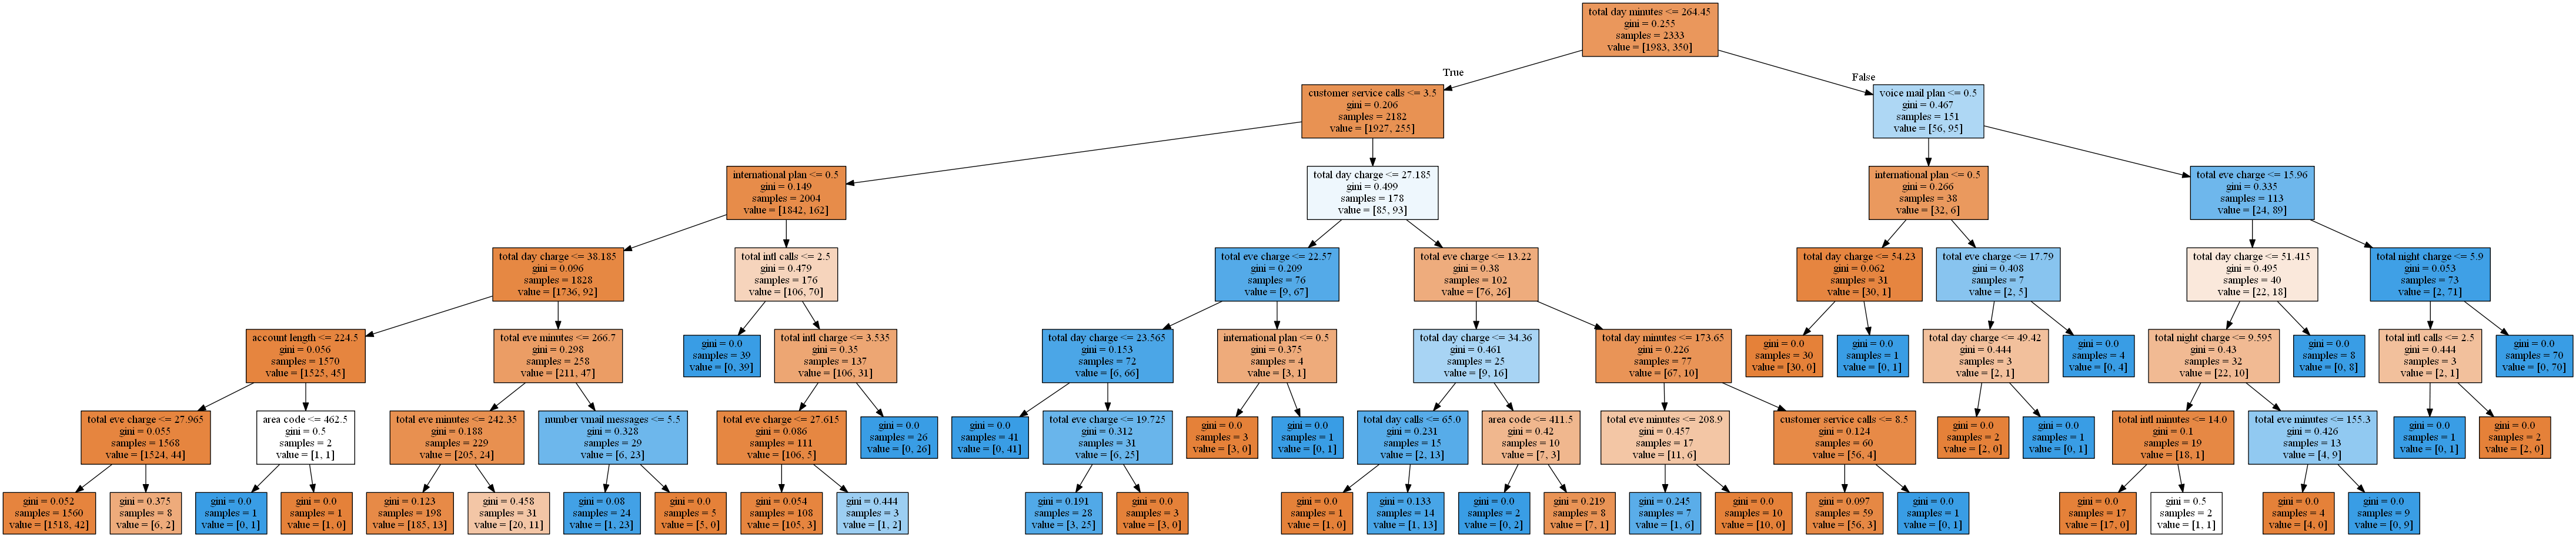

In [38]:
tree_graph_to_png(tree=tree_grid.best_estimator_, feature_names=df.columns, png_file_to_save='topic3_decision_tree4.png')


from IPython.display import Image
from IPython.core.display import HTML 
PATH = "topic3_decision_tree4.png"
Image(filename = PATH , width=900, height=900)

Due to the fact that it is not entirely a toy example (its maximum depth is 6), the picture is not that small, but you can zoom in the picture. It is saved in the directory with the name 'topic3_decision_tree4.png', from where you are running this notebook. 

Now, let's tune the number of neighbors $k$ for k-NN:

In [ ]:
from sklearn.pipeline import Pipeline

knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

knn_params = {'knn__n_neighbors': range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params,
                        cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train, y_train)

knn_grid.best_params_, knn_grid.best_score_

In [ ]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout)) 

Here, the tree proved to be better than the nearest neighbors algorithm: 94.2%/94.6% accuracy for cross-validation and hold-out respectively. 

### Complex Case for Decision Trees

To continue the discussion of the pros and cons of the two methods in question, let's consider a simple classification task, where a tree would perform well but does it in an "overly complicated" manner. Let's create a set of points on a plane (2 features), each point will be one of two classes (+1 for red, or -1 for yellow). If you look at it as a classification problem, it seems very simple: the classes are separated by a line. 

In [ ]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, 
                                 x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1 = np.random.randint(x1_min, x1_max)
        x2 = np.random.randint(x2_min, x2_max)
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)

X, y = form_linearly_separable_data()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='black');

However, the border that the decision tree builds is too complicated; plus the tree itself is very deep. Also, imagine how badly the tree will generalize to the space beyond the $30 \times 30$ squares that frame the training set.

In [ ]:
tree = DecisionTreeClassifier(random_state=17).fit(X, y)

xx, yy = get_grid(X)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title('Easy task. Decision tree compexifies everything');

We got this overly complex construction, although the solution is just a straight line $x_1 = x_2$.

In [ ]:
tree_graph_to_png(tree=tree, feature_names=['x1', 'x2'], png_file_to_save='topic3_decision_tree5.png')


from IPython.display import Image
from IPython.core.display import HTML 
PATH = "topic3_decision_tree5.png"
Image(filename = PATH , width=800, height=800)

The method of one nearest neighbor does better than the tree. The following cell will take approx 4-5 minutes to run. 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1,n_jobs = -1).fit(X, y)

xx, yy = get_grid(X)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);
plt.title('Easy task, kNN. Not bad');

###  Decision Trees and k-NN in a Task of MNIST Handwritten Digits Recognition

Now let's have a look at how these 2 algorithms perform on a real-world task. We will use the `sklearn` built-in dataset on handwritten digits. This task is an example where k-NN works surprisingly well.
 
Pictures here are 8x8 matrices (intensity of white color for each pixel). Then each such matrix is "unfolded" into a vector of length 64, and we obtain a feature description of an object.
 
Let's draw some handwritten digits. We see that they are distinguishable.

In [1]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target

X[0,:].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [2]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16,6))
for i in range(4):
    axes[i].imshow(X[i,:].reshape([8,8]));

NameError: name 'plt' is not defined

Next, let's do the same experiment as in the previous task, but, this time, let's change the ranges for tunable parameters.

Let's select 70% of the dataset for training (`X_train`, `y_train`) and 30% for holdout (`X_holdout`, `y_holdout`). The holdout set will not participate in hyper-parameters tuning; we will use it at the end to check the quality of the resulting model.

In [3]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,random_state=17)

NameError: name 'train_test_split' is not defined

Let’s train a decision tree and k-NN with our random hyper-parameters.

In [ ]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('knn', KNeighborsClassifier(n_neighbors=10))])

tree.fit(X_train, y_train)
knn_pipe.fit(X_train, y_train);

Now let’s make predictions on our holdout set. We can see that k-NN did much better, but note that this is with random hyper-parameters.  

In [ ]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn_pipe.predict(X_holdout)
print (f"K-Nearest neighbor accuracy is {accuracy_score(y_holdout, knn_pred)}")
print (f"Decision tree accuracy is {accuracy_score(y_holdout, tree_pred)}")

Now let’s tune our hyper-parameters using cross-validation as before, but now we’ll take into account that we have more features than in the previous task: 64. 

In [ ]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
               'max_features': [1, 2, 3, 5, 10, 20 ,30, 50, 64]}

tree_grid = GridSearchCV(tree, tree_params, 
                         cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)


Let's see the best parameters combination and the corresponding accuracy from cross-validation:



In [ ]:
tree_grid.best_params_, tree_grid.best_score_ 

In [ ]:
print (f"Decision tree accuracy is {accuracy_score(y_holdout,  tree_grid.predict(X_holdout))}") 

That has already passed 66% but not quite 97%. kNN works better on this dataset. In the case of one nearest neighbor, we were able to reach 99% guesses on cross-validation.  

In [ ]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5)) 

Results
*(Legend: CV and Holdout are average shares of the correct answers on cross-model validation and hold-out sample. DT stands for a decision tree, k-NN stands for k-nearest neighbors.

|   algo\eval      |   CV  | Holdout |  
|---------|-------|---------|
| **DT**  | 0.844 |  0.838  |  
| **kNN** | 0.987 |  0.983  |

The **conclusion** of this experiment (and general advice): first check simple models on your data: decision tree and nearest neighbors. It might be the case that these methods already work well enough.


This notebook is adaption from the following kaggle notebook https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn.